# When is Brandenburg Covered in its Entirety?

When trying to generate mosaics covering the entire federal state of Brandenburg it was discovered that even over relatively long time frames (i.e. four weeks) uncovered areas could be detected.
This discovery stands in contrast with the claim that the revisit time in that given latitude would be approximately one week.
This notebook contains the research that was undertaken to find out over which time frame exactly an image of the entire federal state can be generated.

In [1]:
import sentinel_helpers

We first fetch the geometry of the area we are interested in

<AxesSubplot:>

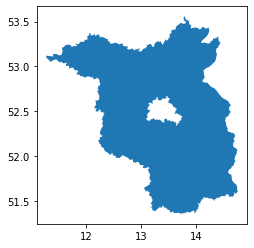

In [2]:
brandenburg = sentinel_helpers.search_osm('Brandenburg, Germany')[:1]
brandenburg.plot()

Now we fetch all available Sentinel-2 level 2a products on SciHub in the last year:

In [3]:
import os
from sentinelsat import SentinelAPI

api = SentinelAPI(os.getenv('SCIHUB_USERNAME'), os.getenv('SCIHUB_PASSWORD'))

We simplify the geometry and convert it to wkt we can run intersection queries against the api:

In [4]:
footprint = brandenburg.convex_hull[0].wkt

The time frame we are interested in spans 4 weeks (i.e. approximately one month in the Gregorian calendar):

In [5]:
from datetime import date
import datetime

end_date = date(2020, 7, 1)
start_date = end_date - datetime.timedelta(weeks=4)

## Which Area Exactly is Covered by the Products?

In [6]:
products = api.query(footprint,
                     platformname='Sentinel-2',
                     processinglevel='Level-2A',
                     date=(start_date, end_date))
products = api.to_geodataframe(products)

Querying products: 100%|██████████| 181/181 [00:03<00:00, 24.77 products/s]
/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Let's verify visually that we have enough products to cover the area we are interested in:

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

<AxesSubplot:>

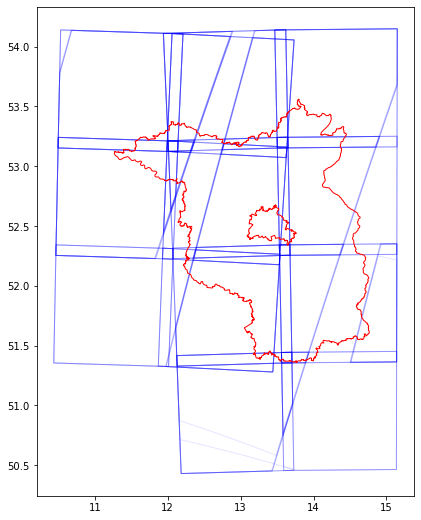

In [8]:
# let's get an overview of all products
ax = products.plot(color='None', edgecolor='blue', alpha=0.1, figsize=(16, 9))
brandenburg.plot(ax=ax, color='None', edgecolor='gray')

In order to be able to conviently reference the products by UTM tile we extract that information from the product identifier and save it in a separate column.

In [9]:
products['tile'] = products['identifier'].map(lambda s: s.split('_')[5])
products['tile'].head()

eb1fec8e-d933-48c3-99f2-c2b3731dc5a1    T33UUS
a87c7ff5-8664-4002-9258-7b1508a1de78    T33UUT
f07d56ae-df3c-4402-a63d-e3879e4e671d    T33UVV
6c1721a4-3628-49dd-a312-788111bf2ce9    T33UVU
8c3b2e01-7c8b-43d4-b3e0-1a6a376cdd65    T33UVT
Name: tile, dtype: object

Some UTM tiles start with `T32` while others start with `T33`:

In [10]:
products['tile'].str.startswith('T32').sum(), products['tile'].str.startswith('T33').sum()

(75, 106)

Which tile exactly a product is covering depends on the exact position of the satellite. It also determines the angle of the cutoff of the pixel image. In the plot below `T32…` tiles are plotted in blue and `T33…` tiles are plotted in green:

<AxesSubplot:>

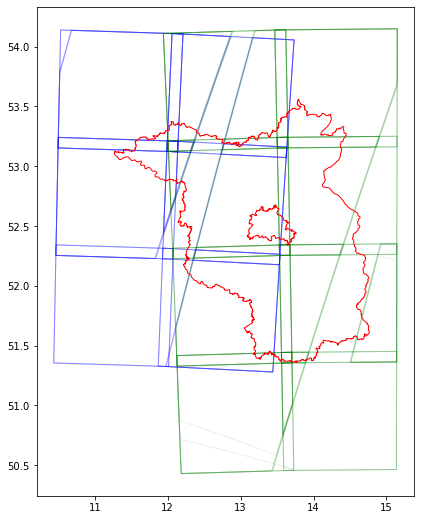

In [11]:
ax = products[products['tile'].str.startswith('T32')].plot(color='None', edgecolor='blue', alpha=0.1, figsize=(16, 9))
products[products['tile'].str.startswith('T33')].plot(ax=ax, color='None', edgecolor='green', alpha=0.1)
brandenburg.plot(ax=ax, color='None', edgecolor='gray')

We can see that because the satellites are crossing the area more frequently than their repeat frequency, the area covered per orbit is slightly different. This can be made more complicated when dealing with hardware failures. 

Each orbit gets a designated `orbitnumber` which allows us to plot all products in our area per orbit.

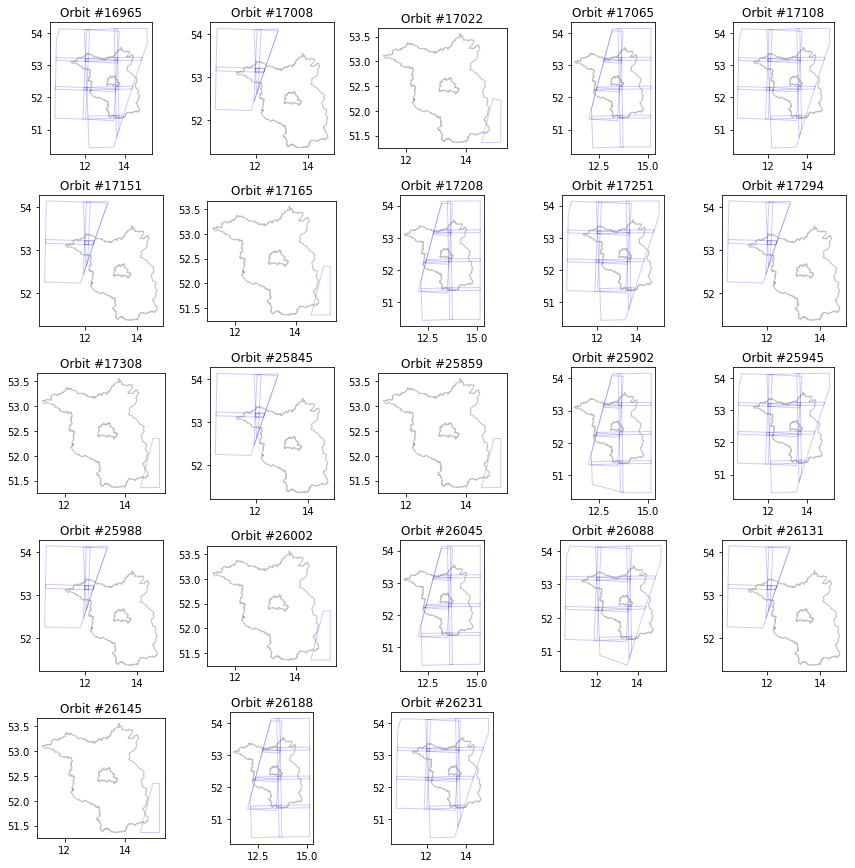

In [28]:
import math

orbits = products['orbitnumber'].unique()

ncols = 5
fig, axs = plt.subplots(nrows=math.ceil(len(orbits) / ncols), ncols=ncols, figsize=(12, 12))
fig.tight_layout(h_pad=2) # h_pad=2 works better if we have titles in our subplots
axs = axs.flatten() # lets us address a subplot with a 1d index

for ax, orbit in zip(axs, sorted(orbits)):
    ax.set_title('Orbit #{}'.format(orbit))
    per_orbit = products[products['orbitnumber'] == orbit]
    per_orbit.plot(ax=ax, color='None', edgecolor='blue', alpha=0.2)
    brandenburg.plot(ax=ax, color='None', edgecolor='gray', alpha=0.5)
    
# hide empty subplots
for ax in axs[len(orbits):]:
    ax.axis('off')

We can nicely see a repeating pattern. The covered area shifts slightly to the left in each pass before re-appearing on the right. The exact same area is covered every 143 orbits, which is one repeat cycle.

The oribt numbers are counted per Sentinel-2 satellite. There are currently two satellites in the Sentinel-2 program, S2A and S2B. These can be identified using the product `title`:

In [30]:
products['title'].apply(lambda t: t.split('_')[0]).unique()

array(['S2A', 'S2B'], dtype=object)

S2A has been launched earlier, which is why the orbit numbers are higher:

In [13]:
products[products['title'].str.startswith('S2A')]['orbitnumber'].unique()

array([26231, 26188, 26145, 26131, 26088, 26045, 26002, 25988, 25945,
       25902, 25859, 25845])

In [14]:
products[products['title'].str.startswith('S2B')]['orbitnumber'].unique()

array([17308, 17294, 17251, 17208, 17165, 17151, 17108, 17065, 17022,
       17008, 16965])

## Ensuring Complete Coverage

What is the minimum time span in those four weeks to ensure a coverage of all of Brandenburg?
To find out we iterate through the returned products, for each iteration $i$ unifying the associated product's geometry $P_i$ with all products we already iterated through:

\begin{align}
P &= \{P_1, P_2, \cdots, P_n\} \\
U_1 &= \{\} \\
U_{n+1} &= U_{n} \cup P_n
\end{align}

Given the shape of Brandenburg $B$ the condition for termination is when $B$ is contained entirely in the unified shape $U_n$:

$$
B = B \cap U_n
$$

In [15]:
brandenburg_geometry = brandenburg.iloc[0].geometry

Before we continue we do a sanity check: Is the total area covered by the returned products big enough to cover the entirety of Brandenburg?

Are the products sorted in the order of their capture or do we need to sort them?

In [35]:
%time products['geometry'].unary_union.contains(brandenburg_geometry)

CPU times: user 42.1 ms, sys: 3.37 ms, total: 45.5 ms
Wall time: 44.1 ms


True

It is!
The `unary_union` operation is also sufficiently small for the algorithm to terminate in a reasonable amount of time.

### Coverage Algorithm

In [32]:
import numpy as np
import pandas  as pd
import geopandas as gpd

# we use tqdm to display progress bars
from tqdm.notebook import tqdm

We would like 

In [17]:
pd.Series(np.unique(products['beginposition'].values)).is_monotonic

True

No need to sort.
If we iterate through them in the order they are returned from the API we can get a set of products covering our area of interest that is…

1. …as close to the start of our observation time span as possible
2. …captured over a time span that is as small as possible

The code for the algorithm is very short thanks to the `shapely` geometry operators:

In [20]:
for idx, product in tqdm(products.iterrows(), total=len(products)):
    union = products.loc[:idx].unary_union
    if union.contains(brandenburg_geometry):
        break

The blue line represents the outline of the area we selected to cover the geometry shown in pink.

<AxesSubplot:>

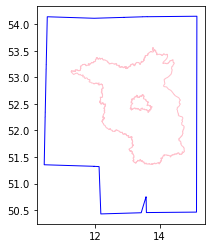

In [22]:
ax = gpd.GeoSeries(union).plot(color='None', edgecolor='b', alpha=0.2)
brandenburg.plot(ax=ax, color='None', edgecolor='gray')

We can see that our algorithm worked.

What is the delta between the capture date of the first and the last product contained in our union?

In [23]:
products_in_union = products.loc[:idx]
products_in_union.iloc[0]['beginposition'] - products_in_union.iloc[-1]['beginposition']

Timedelta('3 days 00:10:00')

This small delta suggests that only few orbits were needed to capture the entire area:

In [33]:
products_in_union['orbitnumber'].unique()

array([26231, 17308, 17294, 26188])

## Considering Cloud Coverage

For the union above we did not consider cloud coverage at all.
A plot of the cloud coverage can give us an estimate of how useful the combined image would be without plotting it:

<AxesSubplot:ylabel='Frequency'>

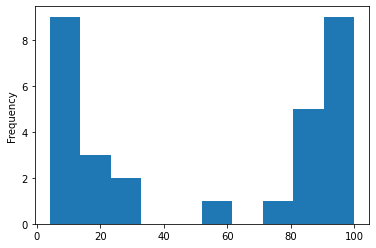

In [34]:
products_in_union['cloudcoverpercentage'].plot.hist()

Not good.
A cloud coverage of 100% is not of much use for us because it amounts to an image that does not contain any of the surface features we are interested in.

We might have to make a compromise between recency and cloud coverage in some cases.

In [25]:
products_in_union.iloc[0]['beginposition'], products_in_union.iloc[-1]['beginposition']

(Timestamp('2020-06-30 10:20:31.024000'),
 Timestamp('2020-06-27 10:10:31.024000'))

In [26]:
less_cloudy_products = products[products['cloudcoverpercentage'] < 50]
for idx, product in tqdm(less_cloudy_products.iterrows(), total=len(less_cloudy_products)):
    union = less_cloudy_products.loc[:idx].unary_union
    if union.contains(brandenburg_geometry):
        break

In [27]:
ax = gpd.GeoSeries(union).plot(color='', edgecolor='b')
brandenburg.plot(ax=ax, color='', edgecolor='pink')

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


ValueError: Expected 2-dimensional array, got 1

ValueError: Expected 2-dimensional array, got 1

<Figure size 432x288 with 1 Axes>

In [ ]:
products_in_union = less_cloudy_products.loc[:idx]
products_in_union.iloc[0]['beginposition'] - products_in_union.iloc[-1]['beginposition']

In [ ]:
products_in_union['cloudcoverpercentage'].plot.hist()

We can find less cloudy products if we increase the timespan to 15 days.

In [ ]:
products_in_union.iloc[0]['beginposition'], products_in_union.iloc[-1]['beginposition']

In [ ]:
products_in_union

Let's try to further reduce the amount of products we need to download by dropping identical geometries, keeping the one with the smallest cloud cover:

In [ ]:
deduplicated = products_in_union.sort_values(by='cloudcoverpercentage').drop_duplicates(subset=['geometry'])
deduplicated

In [ ]:
deduplicated['cloudcoverpercentage'].plot.hist()